In [2]:
import pandas as pd
import numpy as np
import os
import csv
from sklearn.utils import shuffle

In [2]:
# 2초 moving average
def moving_average(a, n=200):
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
SRATE = 100
MINUTES_AHEAD = 5
MAX_CASES = 300
TEST_NAME = 'test1'

In [4]:
# 전체 art 케이스를 로딩
# 제외 기준, 포함 기준은 다 포함 되어있음
df_cases = pd.read_csv("train_cases1.csv")
#df_cases = shuffle(df_cases)

In [5]:
# 최종 데이터셋 출력 파일 생성
fo = csv.writer(open('{}.csv'.format(TEST_NAME), 'w', newline=''), quoting=csv.QUOTE_MINIMAL)
row = ['hypotension', 'age', 'sex', 'weight', 'height']
for i in range(2000):
    row.append('abp_{}'.format(i+1))
fo.writerow(row)

16928

In [6]:
# 각 case를 돌면서
ncase = 0
np.errstate(invalid='ignore')
for _, row in df_cases.iterrows():
    caseid = row['caseid']
    age = row['age']
    sex = row['sex']
    height = row['height']
    weight = row['weight']

    print('{}...'.format(caseid), flush=True, end='')

    # load wav data
    vals = pd.read_csv('train_data/'+str(caseid)+'.csv', na_values=['nan','-nan(ind)']).values[:,0].astype(float)
    print(vals,len(vals))
    if len(vals) < 2 * 3600 * 100:
        print('caselen < 2')
        continue

    # 앞 뒤의 결측값을 제거
    case_valid_mask = ~np.isnan(vals)
    vals = vals[(np.cumsum(case_valid_mask) != 0) & (np.cumsum(case_valid_mask[::-1])[::-1] != 0)]

    if np.nanmax(vals) < 120:
        print('mbp < 120')
        continue

    # 20sec (20 00) - 5min (300 00) - 1min (60 00) = 38000 sample
    i = 0
    nsamp = 0
    nevent = 0
    while i < len(vals) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60):
        segx = vals[i:i + SRATE * 20]
        segy = vals[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (1 + MINUTES_AHEAD) * 60)]

        # 결측값 10% 이상이면
        if np.mean(np.isnan(segx)) > 0.1 or \
            np.mean(np.isnan(segy)) > 0.1 or \
            np.nanmax(segx) > 200 or np.nanmin(segx) < 20 or \
            np.nanmax(segy) > 200 or np.nanmin(segy) < 20 or \
            np.nanmax(segx) - np.nanmin(segx) < 30 or \
            np.nanmax(segy) - np.nanmin(segy) < 30 or \
            (np.abs(np.diff(segx[~np.isnan(segx)])) > 30).any() or \
            (np.abs(np.diff(segy[~np.isnan(segy)])) > 30).any():
            i += SRATE  # 1 sec 씩 전진
            continue

        # 출력 변수
        segy = moving_average(segy, 2 * SRATE)  # 2 sec moving avg
        event = 1 if np.nanmax(segy) < 65 else 0

        if event:  # event
            row = [event, age, sex, weight, height]
            row.extend(np.round(segx, 2))
            fo.writerow(row)
            nevent += 1
            nsamp += 1
        elif np.nanmin(segy) > 65:  # non event
            row = [event, age, sex, weight, height]
            row.extend(np.round(segx, 2))
            fo.writerow(row)
            nsamp += 1

        i += 30 * SRATE  # 30sec

    if nsamp > 0:
        print('{}: {} ({:.1f}%)'.format(caseid, nsamp, nevent * 100 / nsamp))
        ncase += 1

    if ncase >= MAX_CASES:
        break


1...[ -8.8  -7.8  -7.8 ...  13.9  -0.9 -13.7] 1154030
1: 226 (10.2%)
4...[-3.9 -3.9 -3.9 ...  1.1  1.1  1.1] 2098939
4: 441 (0.0%)
7...[-3.9 -3.9 -3.9 ... -5.8 -5.8 -5.8] 1576924
7: 301 (0.0%)
10...[-17.7 -17.7 -17.7 ...   2.1   2.1   2.1] 2098809
10: 489 (8.4%)
13...[-11.8 -11.8 -11.8 ...  -1.9  -2.9  -1.9] 1081034
13: 106 (19.8%)
16...[  3.    2.1   2.1 ...  21.8 -18.7  28.7] 1286410
16: 312 (1.3%)
17...[-7.8 -7.8 -7.8 ... -4.9 -3.9 -3.9] 2036829
17: 115 (27.0%)
19...[ -2.9  -2.9  -2.9 ...  32.7 -14.7  11.9] 2757104
19: 440 (15.5%)
20...[-0.9  0.1 -0.9 ...  5.   5.   4. ] 2647429
20: 653 (0.2%)
22...[-23.6 -22.6 -22.6 ... -11.8 -11.8 -10.8] 1437210
22: 320 (0.0%)
24...[-4.956e+02 -4.956e+02 -4.956e+02 ...  1.000e-01  1.000e-01  1.000e-01] 648818
caselen < 2
25...[  2.1   2.1   2.1 ... -22.6  27.7 -12.8] 1483206
25: 381 (0.5%)
26...[3.  3.  4.  ... 3.  4.  2.1] 1070814
26: 162 (0.0%)
27...[1.1 1.1 1.1 ... 1.1 1.1 1.1] 1786893
27: 451 (1.1%)
28...[4. 4. 4. ... 5. 5. 4.] 2690152
28: 657

In [7]:
# 데이터를 다시 읽고
df = pd.read_csv('{}.csv'.format(TEST_NAME))
#df = shuffle(df)  # 무작위 배치

In [8]:
# 분리하여 저장
df['hypotension'].to_csv('{}_y.csv'.format(TEST_NAME), header=False, index=False)
df.drop(columns='hypotension').to_csv('{}_x.csv'.format(TEST_NAME), index=False)

In [9]:
df[df['hypotension']==1].index

Int64Index([   68,    69,    70,    71,    72,    73,    74,    75,    76,
               77,
            ...
            14902, 14903, 14904, 14913, 14914, 14915, 14916, 14917, 14918,
            14967],
           dtype='int64', length=477)

In [10]:
li=list(df[df['hypotension']==1].index)

In [11]:
packet = []
tmp = []
v = li.pop(0)
tmp.append(v)
while(len(li)>0):
    vv = li.pop(0)
    if v+1 == vv:
        tmp.append(vv)
        v = vv
    else:
        packet.append(tmp)
        tmp = []
        tmp.append(vv)
        v = vv
packet.append(tmp)


In [12]:
packet

[[68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87],
 [200, 201, 202],
 [986,
  987,
  988,
  989,
  990,
  991,
  992,
  993,
  994,
  995,
  996,
  997,
  998,
  999,
  1000,
  1001,
  1002,
  1003,
  1004,
  1005,
  1006,
  1007],
 [1106, 1107],
 [1160, 1161, 1162, 1163],
 [1185, 1186, 1187],
 [1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222],
 [1261],
 [1480,
  1481,
  1482,
  1483,
  1484,
  1485,
  1486,
  1487,
  1488,
  1489,
  1490,
  1491,
  1492,
  1493,
  1494],
 [1519, 1520, 1521, 1522, 1523, 1524],
 [1578, 1579],
 [1586, 1587],
 [1916],
 [1954,
  1955,
  1956,
  1957,
  1958,
  1959,
  1960,
  1961,
  1962,
  1963,
  1964,
  1965,
  1966,
  1967,
  1968,
  1969,
  1970,
  1971,
  1972,
  1973,
  1974,
  1975,
  1976,
  1977,
  1978,
  1979,
  1980,
  1981,
  1982,
  1983],
 [1990, 1991, 1992],
 [1998, 1999, 2000, 2001, 2002, 2003, 2004],
 [2008, 2009, 2010, 2011, 2012, 2013],
 [2024,
  2025,
  2026,


In [13]:
blood=[]
for i in packet:
    for j in i[2:]:
        if len(i)>2:
            blood.append(j)

In [14]:
df['y']=[0]*len(df)

In [15]:
for i in blood:
    df['y'][i-15]=1

C:\Users\pdj10\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot

In [40]:
df = pd.read_csv('df.csv', index_col=False)
df = df.iloc[:,1:]
df = df.dropna()

In [41]:
df.head()

,hypotension,age,sex,weight,height,abp_1,abp_2,abp_3,abp_4,abp_5,...,abp_1992,abp_1993,abp_1994,abp_1995,abp_1996,abp_1997,abp_1998,abp_1999,abp_2000,y
0,0,77,M,67.5,160.2,91.9,90.9,89.9,89.9,88.0,...,90.9,90.9,89.9,89.9,88.9,89.9,89.9,90.9,91.9,0
1,0,77,M,67.5,160.2,87.0,87.0,86.0,85.0,84.0,...,88.0,81.0,83.0,94.9,104.7,101.8,88.9,74.1,68.2,0
2,0,77,M,67.5,160.2,69.2,64.3,61.3,64.3,70.2,...,72.2,71.2,73.1,74.1,80.1,87.0,96.8,108.7,121.5,0
3,0,77,M,67.5,160.2,82.0,81.0,81.0,79.1,79.1,...,79.1,79.1,79.1,78.1,77.1,76.1,75.1,73.1,72.2,0
4,0,77,M,67.5,160.2,119.6,115.6,117.6,119.6,111.7,...,155.1,153.1,147.2,141.3,135.4,129.4,121.5,114.6,105.7,0


In [42]:
X=df.iloc[:,1:-1]
X=pd.get_dummies(X)
y=df['y']

In [43]:
X.head()

,age,weight,height,abp_1,abp_2,abp_3,abp_4,abp_5,abp_6,abp_7,...,abp_1993,abp_1994,abp_1995,abp_1996,abp_1997,abp_1998,abp_1999,abp_2000,sex_F,sex_M
0,77,67.5,160.2,91.9,90.9,89.9,89.9,88.0,87.0,87.0,...,90.9,89.9,89.9,88.9,89.9,89.9,90.9,91.9,0,1
1,77,67.5,160.2,87.0,87.0,86.0,85.0,84.0,83.0,81.0,...,81.0,83.0,94.9,104.7,101.8,88.9,74.1,68.2,0,1
2,77,67.5,160.2,69.2,64.3,61.3,64.3,70.2,80.1,89.9,...,71.2,73.1,74.1,80.1,87.0,96.8,108.7,121.5,0,1
3,77,67.5,160.2,82.0,81.0,81.0,79.1,79.1,77.1,78.1,...,79.1,79.1,78.1,77.1,76.1,75.1,73.1,72.2,0,1
4,77,67.5,160.2,119.6,115.6,117.6,119.6,111.7,101.8,90.9,...,153.1,147.2,141.3,135.4,129.4,121.5,114.6,105.7,0,1


In [44]:
len(df[df['y']==1])

381

In [45]:
train_x, test_x, train_y, test_y = train_test_split(X,y ,test_size = 0.1)

In [46]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(train_x, train_y)
y_pred = xgb_wrapper.predict(test_x)

In [47]:
confusion_matrix(test_y, y_pred)

array([[1526,    2],
       [  27,    6]], dtype=int64)

In [48]:
test_predicted_prob = xgb_wrapper.predict_proba(test_x)

In [49]:
roc_auc_score(test_y, test_predicted_prob[:,1])

0.9239052831984769

In [50]:
fpr, tpr, thresholds = roc_curve(test_y, test_predicted_prob[:,1])

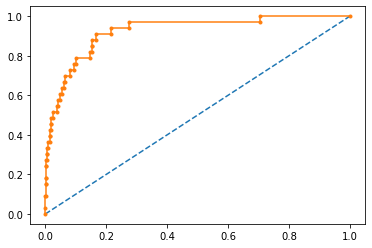

In [51]:
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()